# Basic spectroscopy mode observations with MICADO_Sci

This notebook can be found in the [MICADO package on the IRDB Github repository](https://github.com/astronomyk/irdb/blob/master/MICADO/docs/static/)

In this example we show how to use the basic spectroscopy mode provided with the ``MICADO_Sci`` package.
The output of these spectroscopy simulations is a rectified image of the slit expanded along the wavelength axis.
The x-axis is flux along the slit, the y-axis is wavelength.

Because this is a reduced version (for the sake of speed) of the spectroscopic mode, several of the expected effects, like non-parallel atmospheric background lines are not included. There is also no functionality for turning the slit relative to the parallactic angle. This functionality is available in the pipeline-oriented ``MICADO`` package. The main aim of ``MICADO_Sci`` is to enable the user to quickly iterate on their science use case.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import units as u

import scopesim as sim
import scopesim_templates as sim_tp

%matplotlib inline
%config Completer.use_jedi = False

As always, we must make sure we have the 3 instrument packages needed for SCAO osbservations

In [9]:
sim.server.database.download_package(["locations/Armazones.zip",
                                      "telescopes/ELT.zip",
                                      "instruments/MICADO.zip",
                                      "instruments/MICADO_Sci.zip"])

['F:\\Work\\writings\\ScopeSim_FDR_Docs\\MICADO_ScopeSim_user_manual\\code\\Armazones.zip',
 'F:\\Work\\writings\\ScopeSim_FDR_Docs\\MICADO_ScopeSim_user_manual\\code\\ELT.zip',
 'F:\\Work\\writings\\ScopeSim_FDR_Docs\\MICADO_ScopeSim_user_manual\\code\\MICADO.zip',
 'F:\\Work\\writings\\ScopeSim_FDR_Docs\\MICADO_ScopeSim_user_manual\\code\\MICADO_Sci.zip']

### Set up the Source 

For this basic example we will use the helper function ``spiral_two_component`` from the ``scopesim_templates.basic.galaxy`` submodule.
This function creates a ``Source`` object with two intensity maps and two spectra. 
The two maps represent the distribution of the old (top) and new (bottom) stellar populations in the galaxy.
The associated spectra are taken from the Brown et al (2014) galaxy spectra catalogue and are for an elliptical and a starburst galaxy.

For the purpose of illustrating how the spectroscopy mode works, this approximation will be sufficient.

Here we have selected to scale the galaxy images to 15 arcsec on a side and re-scale the spectra such that a pixel value of 1 corresponds to 15 magnitudes arcsec-2 in the AB system.

As the centre of the galaxy is not exactly in the centre of the iamge, we need to shift the ``Source`` 0.12 arcsec downwards so that the slit catched the galactic bulge

In [10]:
gal = sim_tp.basic.galaxy.spiral_two_component(extent=15*u.arcsec, fluxes=(15, 15)*u.ABmag)
gal.shift(dy=-30*0.004)

https://www.univie.ac.at/simcado/scopesim_templates/spiral_two_component.fits


On the left we have the two intensity maps.
On the right the spectrum associated with these maps.

The vertical line shows were we will set the wavelength that we will centre the observation around

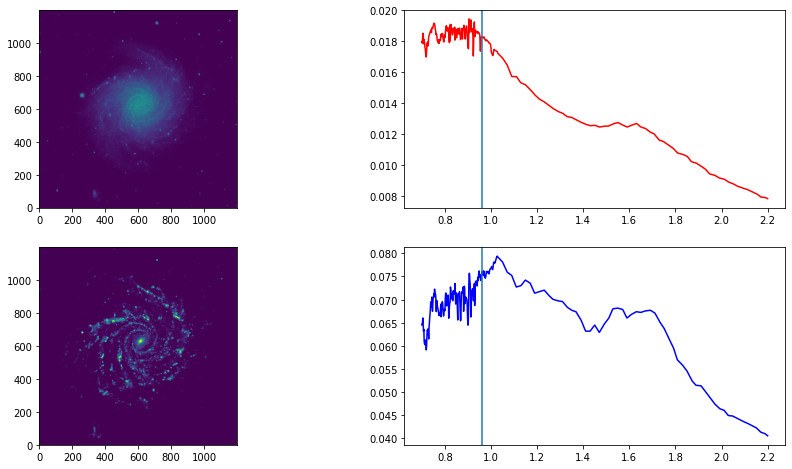

In [11]:
wave = np.linspace(0.7, 2.2, 1001) * u.um

plt.figure(figsize=(15,8))
for i, c in zip([0, 1], "rb"):
    plt.subplot(2,2,2*i+1)
    plt.imshow(gal.fields[i].data, origin="lower")
    plt.subplot(2,2,2*i+2)
    plt.plot(wave, gal.spectra[i](wave), c=c)
    plt.axvline(0.96)

We can visualise approximately what portion of the galaxy that we want to come through the slit.

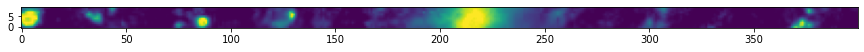

In [12]:
plt.figure(figsize=(15,3))
plt.imshow(gal.fields[1].data[625:635, 400:800], origin="lower")

# Set up MICADO_Sci in SPEC mode

Now we follow the standard proceedure to set up the ``MICADO_Sci`` optical system using a ``UserCommands`` object.
Before we initialise the optical model, we need to set a few parameters.

- ``!SIM.spectral.wave_mid``: [um] sets the wavelength that the simulation will be centred on. In our case we're interested in the feature at 0.96um.
- ``!DET.height``: [pixel] in this context will given the number of spectral bins. As the spectral resolution changes with wavelength, it doesn't make sense to specify a desired wavelength region. Instead the user can choose more or fewer spectral bins on the detector. For the sake of speed we will restrict this simulation to 1000 spectral bins.
- ``!OBS.filter_name``: we can't forget to set the correct filter, otherwise no photons will get through
- ``!OBS.dit``: [s] the exposure time

In [22]:
cmd = sim.UserCommands(use_instrument="MICADO_Sci", set_modes=["SCAO", "SPEC"])
cmd["!SIM.spectral.wave_mid"] = 0.96
cmd["!DET.height"] = 1000
cmd["!OBS.filter_name"] = "Spec_IJ"
cmd["!OBS.dit"] = 3600
cmd["!INST.psf.strehl"]= 0.2

In the ``MICADO_Sci`` package the slit aperture size and position can be set freely. 
The default values correspond to the short-fat slit (3000x50mas) centred on the field of view apnning the x-axis.

In [14]:
cmd["!INST.aperture.x"] = 0             # [arcsec]
cmd["!INST.aperture.y"] = 0
cmd["!INST.aperture.width"] = 3         # [arcsec]
cmd["!INST.aperture.height"] = 0.05    

As always, the standard process for creating an optical model, observing, and reading out the detector window:

In [23]:
micado = sim.OpticalTrain(cmd)
micado.observe(gal)
hdus = micado.readout()

Generated 999 headers from <SpectralTrace> "" : [0.75, 2.5]um : Ext 2 : Aperture 0 : ImagePlane 0
Preparing 999 FieldOfViews


The figure below shows the detector window readout in spectroscopy mode.
It's clear that the spectrum from the new population dominates.
It is now up to the user to decide which regions of the spectrum need to be extracted for analysis.
Below we show a very rudimentary way to extract 1D spectra from the image.

Text(0.5, 0, 'Slit position')

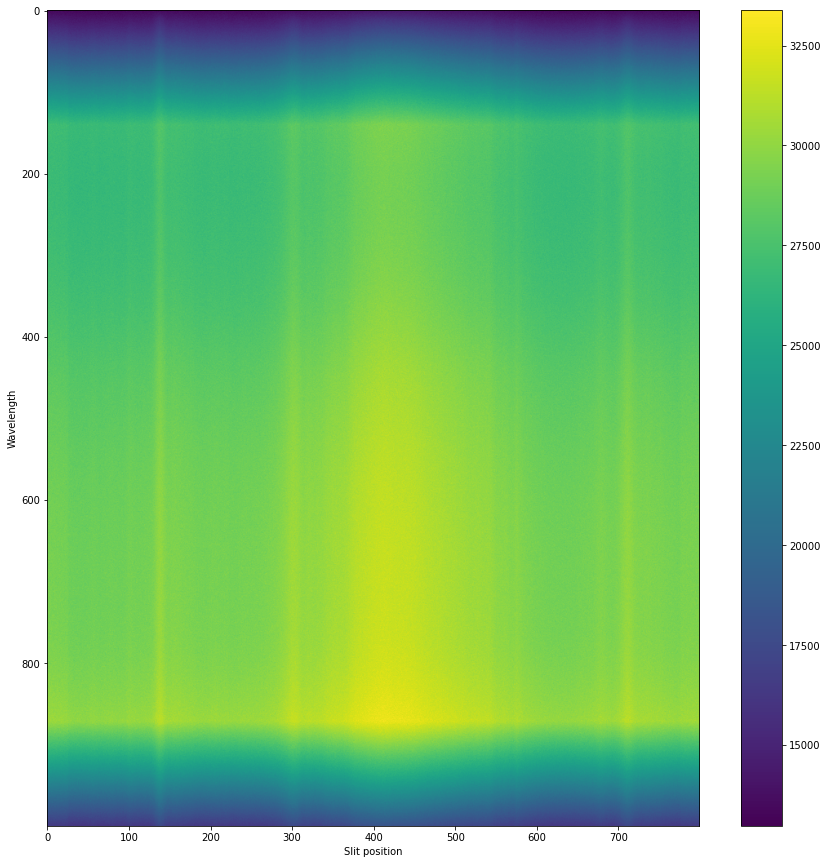

In [26]:
plt.figure(figsize=(15,15))
plt.imshow(hdus[0][1].data)
plt.colorbar()
plt.ylabel("Wavelength")
plt.xlabel("Slit position")

The above image doesn't tell us anything about the wavelength range we're covering, just as the raw MICADO detector readouts will not tell us anything about the observed spectrum. 

We can however extract the wavelength calibration from the MICADO ``OpticalTrain`` object by looking at how many spectral slices (FOV objects) were generated. This requires a bit Python Kung-Fu. Rest assured that this will be easier in later releases of ScopeSim.

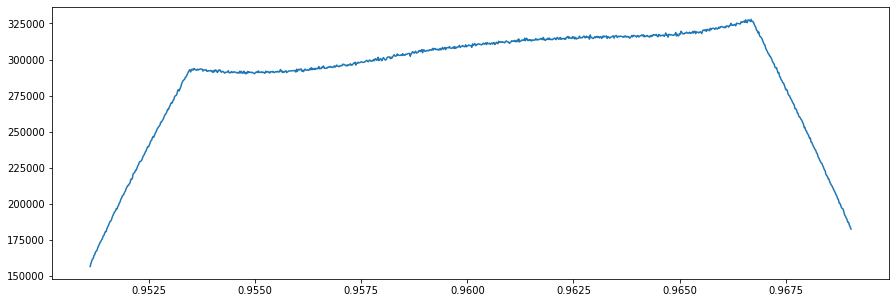

In [25]:
waves = [fov.wavelength.value for fov in micado.fov_manager._fovs_list]
flux = hdus[0][1].data[10:, 400:410].sum(axis=1)

plt.figure(figsize=(15, 5))
plt.plot(waves[9:], flux)